In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_utils import *
import controlpy
import tqdm

### Problem setup
Assume the following state space model:
$$ x_{k+1} = Ax_k + Bu_k + w_k $$
With known noise covariance, and known initial state. We have an initial guess of the system dynamics: 
$$ A_{init} = A + \Delta^A, \\ B_{init} = B + \Delta^B  $$
With the estimated dynamics, we synthesize an infinite horizon LQR controller, which we use for control for a fixed amount of time. When the finite length horizon terminates, we create new estimates of the dynamics from the state-input trajectory as follows:
$$ A^*, B^*\min_{A,B} \sum_{i=0}^{N-1} ||A\hat{x}_i + Bu_i - \hat{x}_{i+1}||_2^2 + \lambda||[A, B]||_F^2$$
 We synthesize a new LQR controller, and perform another episode of control with the new system id, and analyze the convergence of the estimates and trajectories. 

In [2]:
# Dynamics
A_true = np.array([[1,.1],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
N = A_true.shape[0]
M = B_true.shape[1]
x_init = np.array([5, 2])
input_limits = 1 * np.array([-1,1])

# LQR Cost:
Q = np.eye(N)
R = np.eye(M)

# Estimation and Simulation
process_noise_sigma = 5e-3
process_noise = process_noise_sigma * np.eye(N)

# Experiment details
num_iterations = 100
regularization = 0
episode_length = 50
sigma_init_id_error = 5e-1
create_animation = True
animation_file = "trajectory.html"
learning_rate = 1

### Show an initial run with the true dynamics

In [3]:
A_init = A_true
B_init = B_true
K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_init, B_init, Q, R)

In [4]:
x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

In [5]:
x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_sim, N=episode_length, input_limits=input_limits)

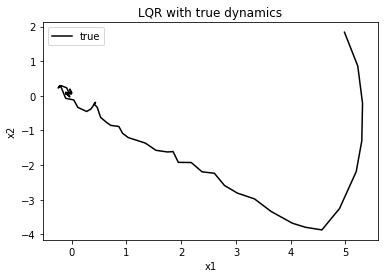

In [6]:
plt.plot(x_traj[:,0], x_traj[:,1],'k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("LQR with true dynamics")
plt.legend(("true", "estimated"))

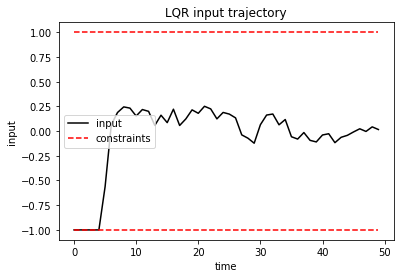

In [7]:
plt.plot(u_traj, "k")
plt.plot(np.ones(len(u_traj)) * input_limits[0], "r--")
plt.plot(np.ones(len(u_traj)) * input_limits[1], "r--")
plt.xlabel("time")
plt.ylabel("input")
plt.title("LQR input trajectory")
plt.legend(("input", "constraints"))

## Set up iterative certainty equivalence

In [8]:
A_est = A_true + sigma_init_id_error * np.random.randn(N,N)
B_est = B_true + sigma_init_id_error * np.random.randn(N,M)

#A_est[0,1] += sigma_init_id_error

TRAJ = "state traj"
COST = "cost"
INPUT_TRAJ = "input trajectory"
ERROR = "regression error"
COV = "covariance"
A_EST = "A_est"
B_EST = "B_est"
GAIN = "K"


data = {}
data[TRAJ] = []
data[COST] = []
data[INPUT_TRAJ] = []
data[ERROR] = [0]
data[COV] = [sigma_init_id_error * np.eye(N + M)]
data[A_EST] = [A_est]
data[B_EST] = [B_est]
data[GAIN] = []
data["process noise"] = process_noise_sigma

### Run initial iteration with random dynamics

In [9]:
x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_init, B_init, Q, R)
x_traj, u_traj, cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_true,
                                            N=episode_length, input_limits=input_limits)

data[TRAJ].append(x_traj)
data[INPUT_TRAJ].append(u_traj)
data[COST].append(cost)
data[GAIN].append(K)

### Run iterative LQG + system ID

In [10]:
for _ in tqdm.tqdm(range(num_iterations)):
    A_est_new, B_est_new, cov, error = regression(data[TRAJ][-1], data[INPUT_TRAJ][-1], regularization)
    A_est = (1 - learning_rate) * A_est + learning_rate * A_est_new
    B_est = (1 - learning_rate) * B_est + learning_rate * B_est_new
    
    x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
    K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)
    x_traj, u_traj, cost = sim_traj(A_true, B_true, K, Q, R, process_noise, x_init_sim,
                                                N=episode_length, input_limits=input_limits)

    data[TRAJ].append(x_traj)
    data[INPUT_TRAJ].append(u_traj)
    data[COST].append(cost)
    data[COV].append(cov)
    data[ERROR].append(error)
    data[A_EST].append(A_est)
    data[B_EST].append(B_est)
    data[GAIN].append(K)
    

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100.68it/s]


## Plot results

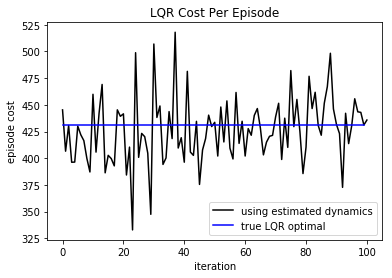

In [11]:
plt.plot(data[COST], 'k')
plt.plot(true_opt_cost * np.ones(num_iterations), "b")
plt.xlabel("iteration")
plt.ylabel("episode cost")
plt.title("LQR Cost Per Episode")
plt.legend(("using estimated dynamics", "true LQR optimal"))

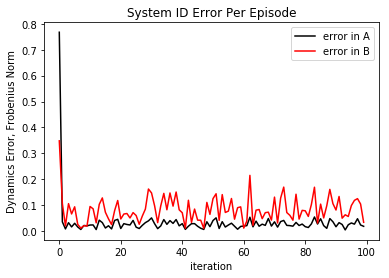

In [12]:
A_error = [np.linalg.norm(data[A_EST][i] - A_true) for i in range(num_iterations)]
B_error = [np.linalg.norm(data[B_EST][i] - B_true) for i in range(num_iterations)]
plt.plot(A_error, "k")
plt.plot(B_error, "r")
plt.xlabel("iteration")
plt.ylabel("Dynamics Error, Frobenius Norm")
plt.title("System ID Error Per Episode")
plt.legend(("error in A", "error in B"))

Text(0.5,1,'RMSE of Sys ID Per Episode')

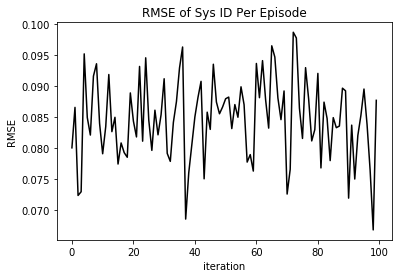

In [13]:
est_errors = [np.mean(np.linalg.norm(err, axis=1)) for err in data[ERROR][1:]]
plt.plot(est_errors,"k")
plt.xlabel("iteration")
plt.ylabel("RMSE")
plt.title("RMSE of Sys ID Per Episode")

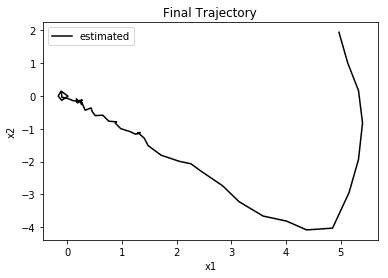

In [14]:
traj = data[TRAJ][-1]
plt.plot(traj[:,0], traj[:,1], "k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Final Trajectory")
plt.legend(("estimated", "true"))

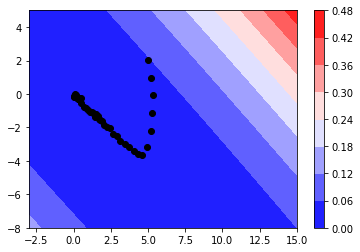

In [15]:
traj_id = 99
X, Y, uncertainties = plot_covariance(data[GAIN][traj_id], data[COV][traj_id], process_noise_sigma, (-3,15), (-8,5))
fig = plt.figure()
ax = plt.gca()
c = ax.contourf(X, Y, uncertainties, cmap="bwr")
fig.colorbar(c)
ax.plot(data[TRAJ][traj_id-1][:,0], data[TRAJ][traj_id-1][:,1],"ok")

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


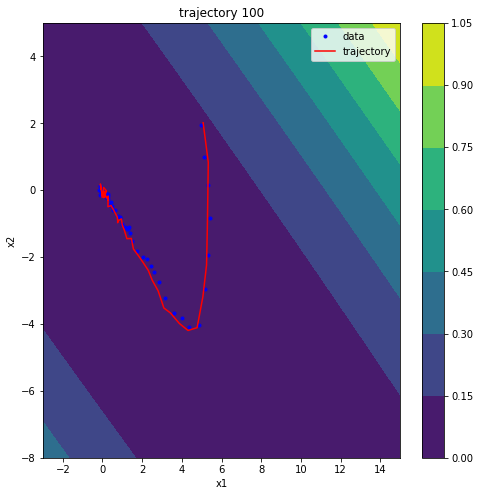

In [16]:
if create_animation:
    animate_single_trajectories(data, animation_file)